# Time Series Analysis with GARCH and ARIMA

In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import normaltest
from tqdm import tqdm
from scipy.stats import norm
pd.options.plotting.backend = "plotly"

In [2]:
def load_time_series():
    """Load time series data from CSV file."""
    df = pd.read_csv("data.csv")
    df = df.set_index("ts_event")
    df_price = df[["price"]]
    df_choice = (df_price.diff())
    df_choice = df_choice[df_choice["price"] != 0.0].dropna()
    df_ts = df_price.loc[df_choice.index]
    df_ts.index.names = ["time"]
    df_ts.index = pd.to_datetime(df_ts.index)
    t_min, t_max = df_ts.index.min(), df_ts.index.max()
    time_series_index = pd.date_range(t_min, t_max, periods=df_ts.shape[0])
    old_index = df_ts.index
    combined_index = old_index.union(time_series_index)
    freq = time_series_index.diff().dropna().mean()
    df_extended = df_ts.reindex(combined_index)
    df_extended = df_extended.interpolate(method="time").ffill().bfill()
    df_ts = df_extended.loc[time_series_index]
    df_ts.index.names = ["time"]

    return df_ts, freq

In [3]:
df_ts, freq = load_time_series()
df_ts["return"] = df_ts["price"].pct_change()
df_ts = df_ts.dropna()
df_ts.head()

,price,return
time,,
2024-07-26 14:00:00.052922432+00:00,164.780969,-0.000904
2024-07-26 14:00:00.095679742+00:00,164.816738,0.000217
2024-07-26 14:00:00.138437053+00:00,164.857368,0.000247
2024-07-26 14:00:00.181194363+00:00,164.833785,-0.000143
2024-07-26 14:00:00.223951674+00:00,164.879932,0.000280


In [21]:
# Préparation des données
returns = df_ts['return'].dropna()
returns_squared = returns**2
nlags = 40

# ACF et PACF
acf_vals = acf(returns, nlags=nlags)
pacf_vals = pacf(returns, nlags=nlags)

acf_sq_vals = acf(returns_squared, nlags=nlags)
pacf_sq_vals = pacf(returns_squared, nlags=nlags)

lags = np.arange(len(acf_vals))

from plotly.subplots import make_subplots

# Création d'une figure 2x2
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "ACF des rendements",
        "PACF des rendements",
        "ACF des rendements au carré",
        "PACF des rendements au carré"
    )
)

# 1. ACF des rendements
fig.add_trace(
    go.Bar(x=lags, y=acf_vals, name="ACF"),
    row=1, col=1
)

# 2. PACF des rendements
fig.add_trace(
    go.Bar(x=lags, y=pacf_vals, name="PACF"),
    row=1, col=2
)

# 3. ACF des rendements au carré
fig.add_trace(
    go.Bar(x=lags, y=acf_sq_vals, name="ACF²"),
    row=2, col=1
)

# 4. PACF des rendements au carré
fig.add_trace(
    go.Bar(x=lags, y=pacf_sq_vals, name="PACF²"),
    row=2, col=2
)

# Layout global
fig.update_layout(
    height=800,
    width=1000,
    showlegend=False,
    template='plotly_white'
)

# Axes
fig.update_xaxes(title_text="Lag", row=1, col=1)
fig.update_yaxes(title_text="Corrélation", row=1, col=1)

fig.update_xaxes(title_text="Lag", row=1, col=2)
fig.update_yaxes(title_text="Corrélation", row=1, col=2)

fig.update_xaxes(title_text="Lag", row=2, col=1)
fig.update_yaxes(title_text="Corrélation", row=2, col=1)

fig.update_xaxes(title_text="Lag", row=2, col=2)
fig.update_yaxes(title_text="Corrélation", row=2, col=2)

fig.show()


In [ ]:
from statsmodels.stats.diagnostic import het_arch

# On prend les rendements (retour) centrés et nettoyés
returns = df_ts['return'].dropna()

# Appliquer le test d'Engle
# L'argument 'nlags' est le nombre de lags à tester dans la variance (ex: 10)
arch_test_result = het_arch(returns, nlags=10)

# Résultats
print("Test d'Engle (ARCH LM Test)")
print(f"Statistique de test : {arch_test_result[0]:.4f}")
print(f"P-value : {arch_test_result[1]:.4f}")
print(f"F-stat : {arch_test_result[2]:.4f}")
print(f"P-value (F) : {arch_test_result[3]:.4f}")

Test d'Engle (ARCH LM Test)
Statistique de test : 33415.7053
P-value : 0.0
F-stat : 3629.5933
P-value (F) : 0.0


In [6]:
split_idx = int(len(df_ts) * 0.8)
train_returns = df_ts['return'].iloc[split_idx-20000:split_idx]
test_returns = df_ts['return'].iloc[split_idx:]

p, q = 1, 1
model = arch_model(train_returns * 100, vol='GARCH', p=p, q=q, rescale=False, dist='t')

model_fit = model.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 31565412.337801002
Iteration:      2,   Func. Count:     22,   Neg. LLF: -55550.073630968516
Optimization terminated successfully    (Exit mode 0)
            Current function value: -55550.073660926406
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2


In [7]:
train_returns.tail()

time
2024-07-26 17:59:59.774409961+00:00   -0.000004
2024-07-26 17:59:59.817167271+00:00   -0.000004
2024-07-26 17:59:59.859924582+00:00   -0.000004
2024-07-26 17:59:59.902681892+00:00   -0.000004
2024-07-26 17:59:59.945439203+00:00   -0.000004
Name: return, dtype: float64

In [16]:
# On part de la série complète
n_test = 1000
returns = df_ts['return'].dropna().astype(float)

# Définir le point de départ (ex : 80% des données en training initial)
split_idx = int(len(returns) * 0.8)

# Préparation
predicted_vol = []
rolling_index = returns.index[split_idx:]
nb_train = 20000

print("Rolling GARCH forecast en cours...")

for i in tqdm(range(split_idx, min(len(returns), split_idx + n_test))):
    # Série d'entraînement jusqu'à i (inclus)
    train_slice = returns.iloc[i-nb_train:i]

    # Fit du modèle GARCH(1,1)
    model = arch_model(train_slice * 100, vol='GARCH', p=1, q=1, rescale=False)
    try:
        model_fit = model.fit(disp='off')
    except:
        predicted_vol.append(np.nan)
        continue

    # Forecast à horizon 1
    forecast = model_fit.forecast(horizon=1)
    var = forecast.variance.values[-1, 0]
    predicted_vol.append(np.sqrt(var))

# Assemblage des résultats
df_forecast = pd.DataFrame({
    'predicted_vol': predicted_vol
}, index=rolling_index[:n_test])
df_forecast.head()
true_vol = test_returns.rolling(window=50).std() * 100

Rolling GARCH forecast en cours...


100%|██████████| 1000/1000 [01:17<00:00, 12.85it/s]


(np.float64(0.026554339569577756), np.float64(0.9999999999965995), 0.0026539762631495466, 0.9999999999966054)
P-value du test de normalité : 0.0000


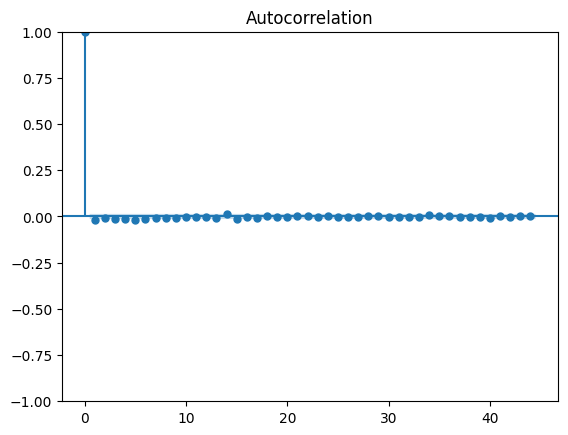

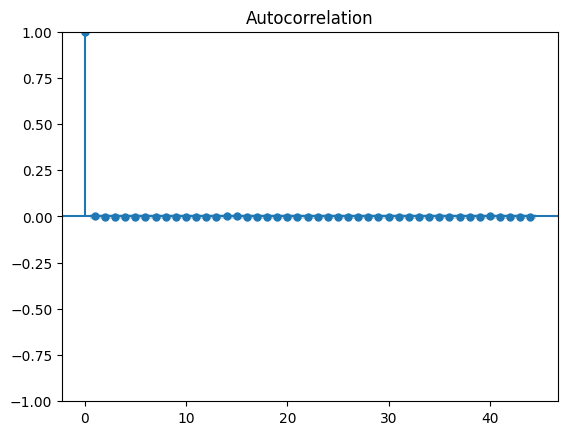

In [17]:
resid = model_fit.std_resid.dropna()

# ACF des résidus
plot_acf(resid)
plot_acf(resid**2)

print(het_arch(resid, nlags=10))

stat, pval = normaltest(resid)
print(f"P-value du test de normalité : {pval:.4f}")

In [18]:
# 1. Préparer la figure
fig = go.Figure()

# 2. Ajouter la volatilité réelle (empirique)
fig.add_trace(go.Scatter(
    x=df_forecast.index,
    y=true_vol.loc[df_forecast.index],
    mode='lines',
    name='Volatilité empirique (rolling std)',
    line=dict(width=2)
))

# 3. Ajouter la volatilité prédite par GARCH
fig.add_trace(go.Scatter(
    x=df_forecast.index,
    y=df_forecast['predicted_vol'],
    mode='lines',
    name='Volatilité prédite (GARCH)',
    line=dict(width=2, dash='dash')
))

# 4. Layout stylé
fig.update_layout(
    title='Prévision de la volatilité — GARCH vs Réalité',
    xaxis_title='Temps',
    yaxis_title='Volatilité (%)',
    template='plotly_white',
    legend=dict(x=0.01, y=0.99),
    height=600
)

fig.show()

In [19]:
# Préparation des données
returns_pct = test_returns.loc[df_forecast.index] * 100
vol = df_forecast['predicted_vol']

# Courbes ±1 sigma
upper_band = vol
lower_band = -vol

# Créer le graphique
fig = go.Figure()

# 1. Courbe des rendements
fig.add_trace(go.Scatter(
    x=returns_pct.index,
    y=returns_pct,
    mode='lines',
    name='Rendement (%)',
    line=dict(color='black')
))

# 2. Bande supérieure (+σ)
fig.add_trace(go.Scatter(
    x=vol.index,
    y=upper_band,
    mode='lines',
    name='+σ (vol GARCH)',
    line=dict(color='orange', dash='dash')
))

# 3. Bande inférieure (-σ)
fig.add_trace(go.Scatter(
    x=vol.index,
    y=lower_band,
    mode='lines',
    name='-σ (vol GARCH)',
    line=dict(color='orange', dash='dash')
))

# 4. Remplissage entre les bandes
fig.add_trace(go.Scatter(
    x=vol.index.tolist() + vol.index[::-1].tolist(),
    y=upper_band.tolist() + lower_band[::-1].tolist(),
    fill='toself',
    fillcolor='rgba(255,165,0,0.1)',
    line=dict(color='rgba(255,165,0,0)'),
    showlegend=False,
    name='Zone ±σ'
))

# Layout
fig.update_layout(
    title="Rendement avec bande de volatilité GARCH (±σ)",
    xaxis_title="Temps",
    yaxis_title="Rendement (%)",
    template="plotly_white",
    height=600
)

fig.show()